## Loading MNIST

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

input_dim = 28 * 28
hidden_dim = 64
output_dim = 10 
batch_size = 32
learning_rate = 0.001
num_epochs = 30


# Preprocess dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print(len(train_dataset), len(test_dataset))

60000 10000


### MLP model

In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.2):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, output_dim),
            nn.LogSoftmax(dim=1)  # Classification Head
        )

    def forward(self, x):
        return self.model(x)

In [3]:
mlp = MLP(input_dim, hidden_dim, output_dim, dropout_rate=0)
criterion = nn.NLLLoss()
optimizer = optim.SGD(mlp.parameters(), lr=learning_rate)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

## TRAINING LOOP
for epoch in range(num_epochs):
    mlp.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.view(images.size(0), -1)

        outputs = mlp(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    ## EVALUATION ON TEST SET
    mlp.eval()
    running_test_loss = 0.
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.size(0), -1)
            outputs = mlp(images)
            test_loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_test_loss += test_loss

    test_losses.append(running_test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss / len(train_loader):.4f}, Test Loss: {running_test_loss / len(test_loader):.4f}")

Epoch [1/30], Train Loss: 2.2635, Test Loss: 2.2023
Epoch [2/30], Train Loss: 2.0421, Test Loss: 1.7719
Epoch [3/30], Train Loss: 1.3849, Test Loss: 1.0546
Epoch [4/30], Train Loss: 0.8792, Test Loss: 0.7402
Epoch [5/30], Train Loss: 0.6703, Test Loss: 0.5933
Epoch [6/30], Train Loss: 0.5582, Test Loss: 0.5010
Epoch [7/30], Train Loss: 0.4854, Test Loss: 0.4397
Epoch [8/30], Train Loss: 0.4354, Test Loss: 0.3971
Epoch [9/30], Train Loss: 0.4002, Test Loss: 0.3696
Epoch [10/30], Train Loss: 0.3754, Test Loss: 0.3488
Epoch [11/30], Train Loss: 0.3571, Test Loss: 0.3338
Epoch [12/30], Train Loss: 0.3429, Test Loss: 0.3249
Epoch [13/30], Train Loss: 0.3319, Test Loss: 0.3126
Epoch [14/30], Train Loss: 0.3220, Test Loss: 0.3042
Epoch [15/30], Train Loss: 0.3137, Test Loss: 0.2984
Epoch [16/30], Train Loss: 0.3059, Test Loss: 0.2932
Epoch [17/30], Train Loss: 0.2989, Test Loss: 0.2852
Epoch [18/30], Train Loss: 0.2919, Test Loss: 0.2788
Epoch [19/30], Train Loss: 0.2857, Test Loss: 0.2737
Ep

In [4]:
mlp_w_dropout = MLP(input_dim, hidden_dim, output_dim, dropout_rate=0.2)
criterion = nn.NLLLoss()
optimizer = optim.SGD(mlp_w_dropout.parameters(), lr=learning_rate)

do_train_losses = []
do_train_accuracies = []
do_test_losses = []
do_test_accuracies = []

for epoch in range(num_epochs):
    mlp_w_dropout.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.view(images.size(0), -1)

        outputs = mlp_w_dropout(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    do_train_losses.append(running_loss / len(train_loader))
    do_train_accuracies.append(100 * correct / total)

    mlp_w_dropout.eval()
    running_test_loss = 0.
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.size(0), -1)
            outputs = mlp_w_dropout(images)
            test_loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_test_loss += test_loss

    do_test_losses.append(running_test_loss / len(test_loader))
    do_test_accuracies.append(100 * correct / total)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss / len(train_loader):.4f}, Test Loss: {running_test_loss / len(test_loader):.4f}")

Epoch [1/30], Train Loss: 2.2900, Test Loss: 2.2644
Epoch [2/30], Train Loss: 2.2328, Test Loss: 2.1476
Epoch [3/30], Train Loss: 2.0263, Test Loss: 1.6968
Epoch [4/30], Train Loss: 1.5474, Test Loss: 1.1034
Epoch [5/30], Train Loss: 1.1617, Test Loss: 0.7965
Epoch [6/30], Train Loss: 0.9487, Test Loss: 0.6449
Epoch [7/30], Train Loss: 0.8155, Test Loss: 0.5534
Epoch [8/30], Train Loss: 0.7351, Test Loss: 0.4969
Epoch [9/30], Train Loss: 0.6750, Test Loss: 0.4558
Epoch [10/30], Train Loss: 0.6270, Test Loss: 0.4257
Epoch [11/30], Train Loss: 0.5918, Test Loss: 0.4011
Epoch [12/30], Train Loss: 0.5574, Test Loss: 0.3817
Epoch [13/30], Train Loss: 0.5336, Test Loss: 0.3623
Epoch [14/30], Train Loss: 0.5086, Test Loss: 0.3497
Epoch [15/30], Train Loss: 0.4907, Test Loss: 0.3329
Epoch [16/30], Train Loss: 0.4753, Test Loss: 0.3223
Epoch [17/30], Train Loss: 0.4605, Test Loss: 0.3105
Epoch [18/30], Train Loss: 0.4480, Test Loss: 0.3016
Epoch [19/30], Train Loss: 0.4322, Test Loss: 0.2906
Ep

### Bayesian Neural Network

In [6]:
from BayesianNeuralNetwork import BayesianNN
import torch.nn.functional as F

kl_weight = 1e-6

model = BayesianNN(input_size=input_dim, output_size=output_dim, num_hidden_layers=2, layer_width=hidden_dim)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

bay_train_losses = []
bay_train_accuracies = []
bay_test_losses = []
bay_test_accuracies = []

tracked_mu = [model.net[0].mu[0, 0].item()]
tracked_sigma = [model.net[0].rho[0, 0].item()]


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.view(images.size(0), -1)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Ajouter la perte KL
        kl_loss = model.compute_total_kl_loss()
        total_loss = loss +  kl_weight * kl_loss

        # Backward pass et mise à jour des poids
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    first_layer = model.net[0]  # Première couche (BayesianLayer)
    tracked_mu.append(first_layer.mu[0, 0].item())
    tracked_sigma.append(F.softplus(first_layer.rho[0, 0]).item())

    bay_train_losses.append(running_loss / len(train_loader))
    bay_train_accuracies.append(100 * correct / total)

    ## Test
    model.eval()
    running_test_loss = 0.
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.size(0), -1)
            outputs = model(images)
            test_loss = criterion(outputs, labels) + kl_weight * model.compute_total_kl_loss()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_test_loss += test_loss

    bay_test_losses.append(running_test_loss / len(test_loader))
    bay_test_accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss / len(train_loader):.4f}, Test Loss: {running_test_loss / len(test_loader):.4f}")

Epoch [1/30], Train Loss: 2.2161, Test Loss: 1.8097
Epoch [2/30], Train Loss: 1.5438, Test Loss: 1.2974
Epoch [3/30], Train Loss: 1.1870, Test Loss: 1.0556
Epoch [4/30], Train Loss: 1.0178, Test Loss: 0.9517
Epoch [5/30], Train Loss: 0.9210, Test Loss: 0.8674
Epoch [6/30], Train Loss: 0.8544, Test Loss: 0.7942
Epoch [7/30], Train Loss: 0.8101, Test Loss: 0.7555
Epoch [8/30], Train Loss: 0.7735, Test Loss: 0.7298
Epoch [9/30], Train Loss: 0.7464, Test Loss: 0.7085
Epoch [10/30], Train Loss: 0.7244, Test Loss: 0.6944
Epoch [11/30], Train Loss: 0.7035, Test Loss: 0.6603
Epoch [12/30], Train Loss: 0.6840, Test Loss: 0.6566
Epoch [13/30], Train Loss: 0.6703, Test Loss: 0.6425
Epoch [14/30], Train Loss: 0.6539, Test Loss: 0.6315
Epoch [15/30], Train Loss: 0.6392, Test Loss: 0.6232
Epoch [16/30], Train Loss: 0.6335, Test Loss: 0.6027
Epoch [17/30], Train Loss: 0.6191, Test Loss: 0.5963
Epoch [18/30], Train Loss: 0.6048, Test Loss: 0.5912
Epoch [19/30], Train Loss: 0.6021, Test Loss: 0.5801
Ep

## Visualizations

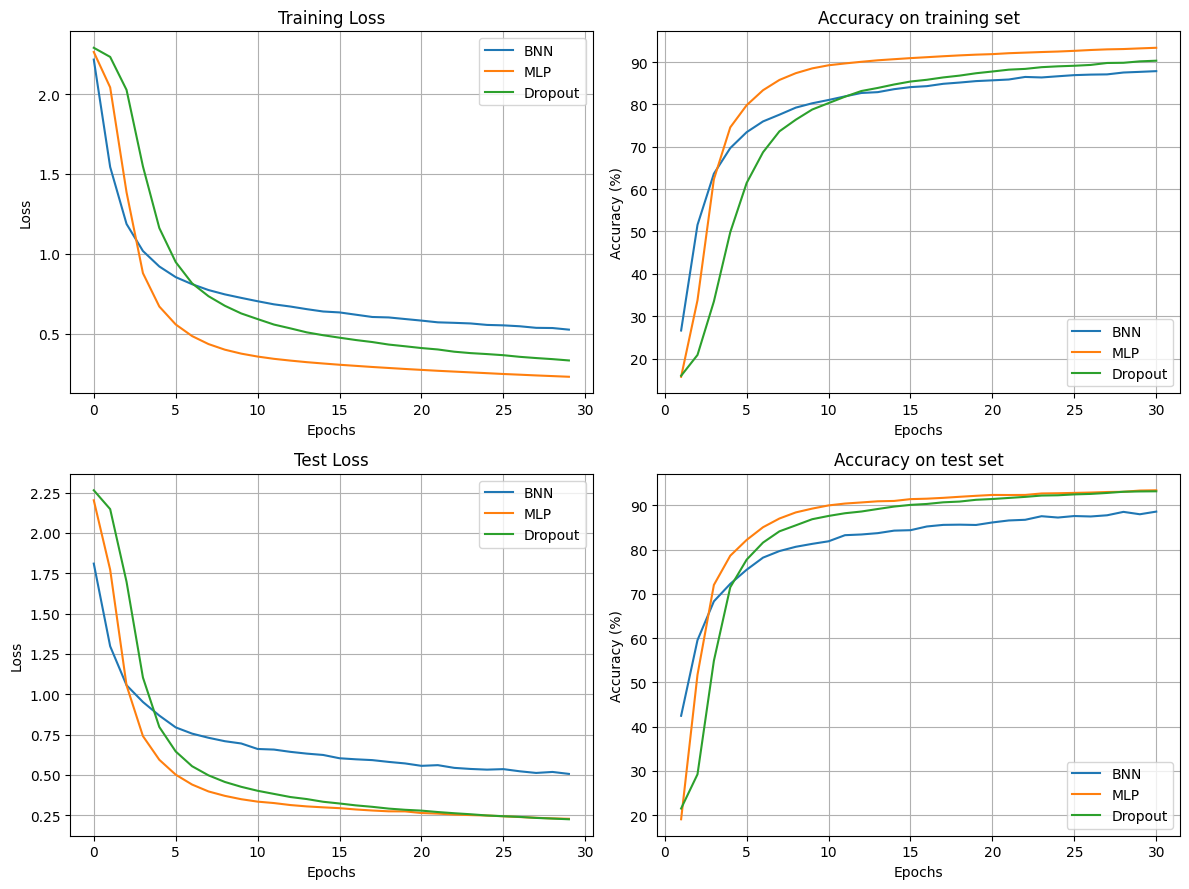

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))

# Courbe de la perte
plt.subplot(2, 2, 1)
plt.plot(range(len(bay_train_losses)), bay_train_losses, label='BNN')
plt.plot(range(len(train_losses)), train_losses, label='MLP')
plt.plot(range(len(do_train_losses)), do_train_losses, label="Dropout")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid()

# Courbe de l'accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, num_epochs + 1), bay_train_accuracies, label='BNN')
plt.plot(range(1, num_epochs + 1), train_accuracies, label="MLP")
plt.plot(range(1, num_epochs + 1), do_train_accuracies, label="Dropout")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy on training set')
plt.legend()
plt.grid()


plt.subplot(2, 2, 3)
plt.plot(range(len(bay_test_losses)), bay_test_losses, label='BNN')
plt.plot(range(len(test_losses)), test_losses, label='MLP')
plt.plot(range(len(do_test_losses)), do_test_losses, label="Dropout")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(range(1, num_epochs + 1), bay_test_accuracies, label='BNN')
plt.plot(range(1, num_epochs + 1), test_accuracies, label="MLP")
plt.plot(range(1, num_epochs + 1), do_test_accuracies, label="Dropout")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy on test set')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


## Weight Distribution

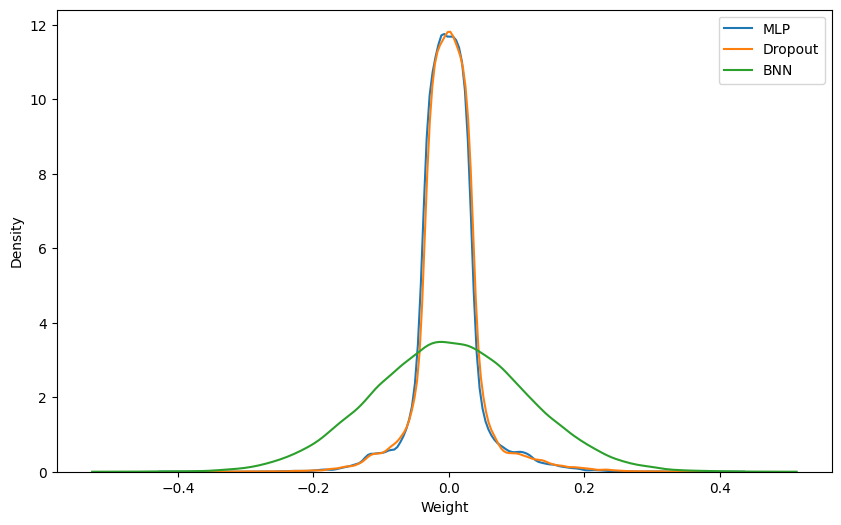

In [10]:
import numpy as np
import seaborn as sns
from BayesianNeuralNetwork import BayesianLayer


mlp_weights = np.concatenate([param.detach().cpu().numpy().flatten() for param in mlp.parameters()])
do_weights = np.concatenate([param.detach().cpu().numpy().flatten() for param in mlp_w_dropout.parameters()])


def get_weights_bayesianNN(model):
    all_w = []

    # Parcourir les couches pour récupérer les paramètres mu
    for module in model.children():
        for layer in module.children():
            if isinstance(layer, BayesianLayer):
                mu = layer.mu.detach().cpu().numpy().flatten()
                sigma = F.softplus(layer.rho).detach().cpu().numpy().flatten()
                all_w.append(mu + sigma * np.random.normal(0, 1, size=mu.size))
                

    all_w = np.concatenate(all_w)
    return all_w

bay_weights = get_weights_bayesianNN(model)



plt.figure(figsize=(10, 6))
sns.kdeplot(mlp_weights, fill=False, label="MLP")
sns.kdeplot(do_weights, fill=False, label="Dropout")
sns.kdeplot(bay_weights.flatten(), fill=False, label="BNN")

plt.xlabel("Weight")
plt.ylabel("Density")
plt.legend()
plt.show()